# HCDR - Phase 2

In [90]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

In [2]:
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    return df


def load_datasets(DATA_DIR, ds_names):
    datasets = {}
    for ds_name in ds_names:
        datasets[ds_name] = load_data(os.path.join(
            DATA_DIR, f'{ds_name}.csv'), ds_name)
    return datasets

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

## Preprocessing and Feature Engineering

### applications.csv
#### Preprocessing

In [3]:
def transform_days(X):
    mask = X > 0
    X[mask] = np.NaN
    # return np.log1p(-1*X)
    return -X

def preprocessing_transformations(df, inplace=False, impute_zero=()):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    right_skewed = ['AMT_ANNUITY']
    left_skewed = []
    days = ['DAYS_EMPLOYED']

    def transform_left_skewed(X): return np.log(1+np.max(X)-X)

    df_new[right_skewed] = np.log1p(df[right_skewed])
    df_new[left_skewed] = transform_left_skewed(df[left_skewed])
    df_new[days] = transform_days(df[days])

    # others
    df_new[impute_zero] = SimpleImputer(strategy='constant', fill_value=0).fit_transform(df_new[impute_zero])
    df_new['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
    df_new['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
    df_new['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
    return df_new

#### Feature Engineering

In [4]:
def add_new_features(df, inplace=False):
    if inplace:
        X = df
    else:
        X = df.copy()
    X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
    X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
    X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / (1+X['DAYS_EMPLOYED'])
    X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
    X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
    X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
    X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
    X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
    X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
    X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
    X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
    X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
    X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
    X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / (1+X['DAYS_EMPLOYED'])
    X['external_source_mean'] = X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    X['cnt_non_child'] = X['CNT_FAM_MEMBERS'] - X['CNT_CHILDREN']
    X['child_to_non_child_ratio'] = X['CNT_CHILDREN'] / X['cnt_non_child']
    X['income_per_non_child'] = X['AMT_INCOME_TOTAL'] / X['cnt_non_child']
    X['credit_per_person'] = X['AMT_CREDIT'] / X['CNT_FAM_MEMBERS']
    X['credit_per_child'] = X['AMT_CREDIT'] / (1 + X['CNT_CHILDREN'])
    X['credit_per_non_child'] = X['AMT_CREDIT'] / X['cnt_non_child']

    return X

### previous_applications.csv

In [5]:
def prevAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    # Sorted df by decsion day
    prev_applications_sorted = df_new.sort_values(
        ['SK_ID_CURR', 'DAYS_DECISION'])

    # Tranform days
    days = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
            'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    df_new[days] = transform_days(df[days])

    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})

    # Compute min, max, min values
    agg_ops = agg_ops = ["min", "max", "mean", "sum"]
    features = [
        'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT',
        'HOUR_APPR_PROCESS_START', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
        'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg({ft: agg_ops for ft in features})
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')

    # Previous Application Count
    prev_appl_count = df_new.groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].nunique().reset_index()
    prev_appl_count.rename(index=str, columns={'SK_ID_PREV': 'previous_applications_count'}, inplace=True)
    aggr_df = aggr_df.merge(prev_appl_count, how='left', on='SK_ID_CURR')

    # Previous applications approved count
    df_new['prev_applications_approved'] = (df_new['NAME_CONTRACT_STATUS'] == 'Approved').astype('int')
    approved_count = df_new.groupby(by=['SK_ID_CURR'])['prev_applications_approved'].sum().reset_index()
    aggr_df = aggr_df.merge(approved_count, how='left', on='SK_ID_CURR')

    # Previous applications refused count
    df_new['prev_applications_refused'] = (df_new['NAME_CONTRACT_STATUS'] == 'Refused').astype('int')
    refused_count = df_new.groupby(by=['SK_ID_CURR'])['prev_applications_refused'].sum().reset_index()
    aggr_df = aggr_df.merge(refused_count, how='left', on='SK_ID_CURR')

    # previous application invalid
    df_new['prev_applications_invalid'] = (df_new['NAME_CONTRACT_STATUS'] == 'Canceled').astype(
        'int') + (df_new['NAME_CONTRACT_STATUS'] == 'Unused offer').astype('int')
    invalid_count = df_new.groupby(by=['SK_ID_CURR'])['prev_applications_invalid'].sum().reset_index()
    aggr_df = aggr_df.merge(invalid_count, how='left', on='SK_ID_CURR')

    # Last application status(approved or rejected?)
    prev_applications_sorted['prevAppl_last_approved'] = (
        prev_applications_sorted['NAME_CONTRACT_STATUS'] == 'Approved').astype('int')
    last_approved = prev_applications_sorted.groupby(by=['SK_ID_CURR'])['prevAppl_last_approved'].last().reset_index()
    aggr_df = aggr_df.merge(last_approved, how='left', on=['SK_ID_CURR'])
    return aggr_df

### POS_CASH_balance.csv
#### Preprocessing



In [6]:
def cash_transform(cash, inplace=False):

    cash['pos_cash_paid_late'] = (cash['SK_DPD'] > 0).astype(int)
    cash['pos_cash_paid_late_with_tolerance'] = (cash['SK_DPD_DEF'] > 0).astype(int)

    def fix_skew_months(X):
        mask = X > 0
        X[mask] = np.NaN
        X = np.log(1+np.max(X)-X)
        return -X

    cash['MONTHS_BALANCE'] = fix_skew_months(cash['MONTHS_BALANCE'])
    cash['CNT_INSTALMENT'] = np.log1p(cash['CNT_INSTALMENT'])
    cash['CNT_INSTALMENT_FUTURE'] = np.log1p(cash['CNT_INSTALMENT_FUTURE'])

    return cash

#### Feature Engineering

In [7]:
def cashAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})

    agg_dict = {
        'MONTHS_BALANCE': ["min", "max", "mean", "sum", "var"],
        'CNT_INSTALMENT': ["min", "max", "mean", "sum", "var"],
        'CNT_INSTALMENT_FUTURE': ["min", "max", "mean", "sum", "var"],
        'SK_DPD': ["min", "max", "mean", "sum", "var"],
        'SK_DPD_DEF': ["min", "max", "mean", "sum", "var"],
        'pos_cash_paid_late': ["mean"],
        'pos_cash_paid_late_with_tolerance': ["mean"]
    }

    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')

    return aggr_df


### installments_payments.csv
#### Preprocessing

In [8]:
def install_transform(install, inplace=False):

    install['installment_payment_diff'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['installment_paid_in_full'] = np.where(install['installment_payment_diff'] <= 0, 1,
                                                   np.where(install['installment_payment_diff'] > 100.00, 0, 1))

    install['installment_days_diff'] = install['DAYS_INSTALMENT'] - install['DAYS_ENTRY_PAYMENT']
    install['installment_paid_in_time'] = np.where(install['installment_days_diff'] >= 0, 1, 0)

    install['install_version'] = (install['NUM_INSTALMENT_VERSION'] > 0).astype(int)

    def left_skew_days(X):
        mask = X > 0
        X[mask] = np.NaN
        X = np.log(1+np.max(X)-X)
        return -X

    left_skewed = ['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']
    install[left_skewed] = left_skew_days(install[left_skewed])
    install['NUM_INSTALMENT_NUMBER'] = np.log1p(install['NUM_INSTALMENT_NUMBER'])

    return install

#### Feature Engineering

In [9]:
def instlmntAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})

    # Compute min, max, min values
    agg_dict = {
        'NUM_INSTALMENT_VERSION': ["min", "max", "mean", "sum", "var"],
        'NUM_INSTALMENT_NUMBER': ["min", "max", "mean", "sum", "var"],
        'DAYS_INSTALMENT': ["min", "max", "mean", "sum", "var"],
        'DAYS_ENTRY_PAYMENT': ["min", "max", "mean", "sum", "var"],
        'AMT_INSTALMENT': ["min", "max", "mean", "sum", "var"],
        'AMT_PAYMENT': ["min", "max", "mean", "sum", "var"],
        'installment_payment_diff': ["min", "max", "mean", "sum", "var"],
        'installment_paid_in_full': ["mean"],
        'installment_days_diff': ["min", "max", "mean", "sum", "var"],
        'installment_paid_in_time': ["mean"],
        'install_version': ["mean"]
    }
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')

    return aggr_df

### credit_card_balance.csv
#### Preprocessing

In [10]:
def credit_transform(credit, inplace=False):

    # # Amount used from limit
    # credit['limit_use'] = credit['AMT_BALANCE'] / (1+credit['AMT_CREDIT_LIMIT_ACTUAL'])
    # # Current payment / Min payment
    # credit['payment_div_min'] = credit['AMT_PAYMENT_CURRENT'] / (1+credit['AMT_INST_MIN_REGULARITY'])
    # # Late payment <-- 'CARD_IS_DPD'
    # credit['late_payment'] = credit['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # # How much drawing of limit
    # credit['drawing_limit_ratio'] = credit['AMT_DRAWINGS_ATM_CURRENT'] / (1+credit['AMT_CREDIT_LIMIT_ACTUAL'])

    def right_skew(X): return np.log1p(X)

    right_skewed = ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                    'AMT_TOTAL_RECEIVABLE', 'CNT_INSTALMENT_MATURE_CUM']
    credit[right_skewed] = right_skew(credit[right_skewed])

    return credit

#### Feature Engineering

In [11]:
def creditAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})

    # Compute min, max, min values
    agg_dict = {
        'AMT_BALANCE': ["min", "max", "mean", "sum", "var"],
        'AMT_CREDIT_LIMIT_ACTUAL': ["min", "max", "mean", "sum", "var"],
        'AMT_DRAWINGS_ATM_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_DRAWINGS_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_DRAWINGS_OTHER_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_DRAWINGS_POS_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_INST_MIN_REGULARITY': ["min", "max", "mean", "sum", "var"],
        'AMT_PAYMENT_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_PAYMENT_TOTAL_CURRENT': ["min", "max", "mean", "sum", "var"],
        'AMT_RECEIVABLE_PRINCIPAL': ["min", "max", "mean", "sum", "var"],
        'AMT_RECIVABLE': ["min", "max", "mean", "sum", "var"],
        'AMT_TOTAL_RECEIVABLE': ["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_ATM_CURRENT': ["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_CURRENT': ["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_OTHER_CURRENT': ["min", "max", "mean", "sum", "var"],
        'CNT_DRAWINGS_POS_CURRENT': ["min", "max", "mean", "sum", "var"],
        'CNT_INSTALMENT_MATURE_CUM': ["min", "max", "mean", "sum", "var"],
        # 'limit_use': ["min", "max", "mean", "sum", "var"],
        # 'payment_div_min': ["min", "max", "mean", "sum", "var"],
        # 'late_payment': ["mean"],
        # 'drawing_limit_ratio': ["min", "max", "mean", "sum", "var"]
    }
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg(agg_dict)
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')

    return aggr_df

### bureau.csv and bureau_balance.csv

In [12]:
def bureauAppsFeaturesAggregater(df, inplace=False):
    # pure state-less transformations
    if inplace:
        df_new = df
    else:
        df_new = df.copy()

    aggr_df = pd.DataFrame({'SK_ID_CURR': df_new['SK_ID_CURR'].unique()})

    # Compute min, max, min values
    agg_ops = agg_ops = ["min", "max", "mean", "sum"]
    features = ['AMT_CREDIT_SUM', 'DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_CREDIT_ENDDATE']
    X = df_new.groupby(["SK_ID_CURR"], as_index=False).agg({ft: agg_ops for ft in features})
    X.columns = X.columns.map(lambda col: '_'.join([x for x in col if x != '']))
    aggr_df = aggr_df.merge(X, how='left', on='SK_ID_CURR')

    return aggr_df

## Pipeline

In [13]:
def make_prep_pipeline(num_selected=None, cat_selected=None):
    num_pipeline = Pipeline([
        ('new_features', FunctionTransformer(add_new_features)),
        ('selector', DataFrameSelector(num_selected)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])
    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_selected)),
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

    data_prep_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])
    return data_prep_pipeline

### Load, Preprocess and Aggregate Data

In [14]:
def load_process_data():
    # load data
    DATA_DIR = "../data"
    # ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
    #             "previous_application","POS_CASH_balance")
    ds_names = ("application_train", "application_test", "bureau", "credit_card_balance", "installments_payments",
                "previous_application", "POS_CASH_balance")
    datasets = load_datasets(DATA_DIR, ds_names)
    print('loaded data')

    # Preparing data
    appl_train = datasets['application_train']
    prevData_aggr = prevAppsFeaturesAggregater(datasets['previous_application'])

    # bureau
    bureauData_aggr = bureauAppsFeaturesAggregater(datasets['bureau'])
    data_aggr = appl_train.merge(prevData_aggr, how='left', on=['SK_ID_CURR'])
    data_aggr = data_aggr.merge(bureauData_aggr, how='left', on=['SK_ID_CURR'])

    # cash
    cash = datasets['POS_CASH_balance']
    cashData_aggr = cashAppsFeaturesAggregater(cash_transform(cash))
    data_aggr = data_aggr.merge(cashData_aggr, how='left', on=['SK_ID_CURR'])
    install = datasets['installments_payments']
    instlmntData_aggr = instlmntAppsFeaturesAggregater(install_transform(install))
    data_aggr = data_aggr.merge(instlmntData_aggr, how='left', on=['SK_ID_CURR'])
    credit = datasets['credit_card_balance']
    creditData_aggr = creditAppsFeaturesAggregater(credit_transform(credit))

    data_aggr = data_aggr.merge(creditData_aggr, how='left', on=['SK_ID_CURR'])
    impute_zero = ['OWN_CAR_AGE', 'previous_applications_count', 'prev_applications_approved',
                   'prev_applications_refused', 'prev_applications_invalid', 'prevAppl_last_approved']
    processed_data = preprocessing_transformations(data_aggr, impute_zero=impute_zero)
    
    
    # test data preprocessing
    
    app_test = datasets['application_test']
    app_test_aggr = app_test.merge(prevData_aggr, how='left', on=['SK_ID_CURR'])
    app_test_aggr = app_test_aggr.merge(bureauData_aggr, how='left', on=['SK_ID_CURR'])
    app_test_aggr = app_test_aggr.merge(cashData_aggr, how='left', on=['SK_ID_CURR'])
    app_test_aggr = app_test_aggr.merge(instlmntData_aggr, how='left', on=['SK_ID_CURR'])
    app_test_aggr = app_test_aggr.merge(creditData_aggr, how='left', on=['SK_ID_CURR'])
    processed_test_data = preprocessing_transformations(app_test_aggr, impute_zero=impute_zero)

    # training

    app_num_attribs = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE',
                       'DAYS_EMPLOYED', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_ID_PUBLISH',
                       'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'OWN_CAR_AGE', 'OBS_30_CNT_SOCIAL_CIRCLE',
                       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
                       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                       'HOUR_APPR_PROCESS_START']
    new_app_attribs = [
        'annuity_income_percentage', 'car_to_birth_ratio', 'car_to_employ_ratio', 'children_ratio',
        'credit_to_annuity_ratio', 'credit_to_goods_ratio', 'credit_to_income_ratio', 'days_employed_percentage',
        'income_credit_percentage', 'income_per_child', 'income_per_person', 'payment_rate', 'phone_to_birth_ratio',
        'phone_to_employ_ratio', 'external_source_mean', 'cnt_non_child', 'child_to_non_child_ratio',
        'income_per_non_child', 'credit_per_person', 'credit_per_child', 'credit_per_non_child']
    prev_aggr_attribs = prevData_aggr.columns.to_list()
    bureau_aggr_attribs = bureauData_aggr.columns.to_list()
    cash_columns = cashData_aggr.columns.to_list()
    install_columns = instlmntData_aggr.columns.to_list()
    credit_columns = creditData_aggr.columns.to_list()

    app_cat_attribs = [
        'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE',
        'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FLAG_MOBIL',
        'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
        'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
        'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
        'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
        'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

    num_attribs = app_num_attribs + new_app_attribs + prev_aggr_attribs + bureau_aggr_attribs + cash_columns + install_columns + credit_columns

    cat_attribs = app_cat_attribs

    return (processed_data, processed_test_data, num_attribs, cat_attribs)


In [15]:
processed_data, processed_test_data, num_attribs, cat_attribs = load_process_data()

loaded data


/var/folders/nl/pxf72qk574l1rzzh347l6x2w0000gn/T/ipykernel_16172/1209287635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[mask] = np.NaN
/Users/deepakduggirala/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
/var/folders/nl/pxf72qk574l1rzzh347l6x2w0000gn/T/ipykernel_16172/3953342808.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [16]:
y = processed_data['TARGET']
X = processed_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
data_prep_pipeline = make_prep_pipeline(num_attribs, cat_attribs)

In [17]:
X_train.shape, X_valid.shape, X_test.shape

((184506, 354), (61502, 354), (61503, 354))

## Feature Selection

In [ ]:
%%time
np.random.seed(42)
pipeline_with_selector = Pipeline([
    ("preparation", data_prep_pipeline),
    ("feature_selector", SelectFromModel(LogisticRegressionCV(
        C=np.logspace(-4, -1, 32),
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=0))),
])

# _ = pipeline_with_selector.fit(X_train, y_train)

In [18]:
%%time
np.random.seed(42)
pipeline_with_selector = Pipeline([
    ("preparation", data_prep_pipeline),
    ("feature_selector", SelectFromModel(LogisticRegression(
        C=0.006,
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=0))),
])

_ = pipeline_with_selector.fit(X_train, y_train)

CPU times: user 31.7 s, sys: 1.76 s, total: 33.5 s
Wall time: 34 s


In [19]:
cat_pipeline = data_prep_pipeline.transformer_list[1][1]
cat_features = [f'{base}_{c}'for base, ohe_c in zip(
    cat_attribs, cat_pipeline.named_steps['ohe'].categories_) for c in ohe_c]
features = num_attribs + cat_features
print(f'features: {len(features)}, num_attribs: {len(num_attribs)}, cat_features: {len(cat_features)}')

selector_model = pipeline_with_selector.named_steps['feature_selector']
selected_features = list(np.array(features)[selector_model.get_support()])
print(f'attribs: {len(num_attribs + cat_attribs)}, features: {len(features)}, selected_features={len(selected_features)}')

selected_attribs = set([f if f in num_attribs else '_'.join(f.split('_')[:-1]) for f in selected_features])
unused_attribs = set(num_attribs+cat_attribs) - selected_attribs

features: 491, num_attribs: 287, cat_features: 204
attribs: 334, features: 491, selected_features=173


In [20]:
selected_attribs = set([f if f in num_attribs else '_'.join(f.split('_')[:-1]) for f in selected_features])
unused_attribs = set(num_attribs+cat_attribs) - selected_attribs

# print('\n\n\nselected')
# print(selected_attribs)

# print('\n\n\nunused')
# print(unused_attribs)

In [21]:
X_train_xfm = pipeline_with_selector.transform(X_train)
X_valid_xfm = pipeline_with_selector.transform(X_valid)
X_test_xfm = pipeline_with_selector.transform(X_test)
X_train_xfm.shape, X_valid_xfm.shape, X_test_xfm.shape

((184506, 173), (61502, 173), (61503, 173))

In [22]:
importances = pd.DataFrame(selector_model.estimator_.coef_.T/np.sum(np.abs(selector_model.estimator_.coef_)), 
                           index=features,
                           columns=['Imp']).abs().sort_values(by='Imp', ascending=False)
importances

,Imp
EXT_SOURCE_3,0.036947
FLAG_OWN_CAR_Y,0.035180
CODE_GENDER_F,0.034490
external_source_mean,0.031756
EXT_SOURCE_2,0.029243
...,...
AMT_INST_MIN_REGULARITY_var,0.000000
AMT_INST_MIN_REGULARITY_min,0.000000
AMT_DRAWINGS_POS_CURRENT_sum,0.000000
AMT_DRAWINGS_POS_CURRENT_mean,0.000000


In [ ]:
importances.to_csv('importances.csv')

## Models Explored

In [ ]:
#del expLog

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Valid Acc",
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Valid AUC",
                                   "Test  AUC"
                                  ])
def log_exp(res, name):
    y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba = res
    y_train_pred = y_train_pred_proba > 0.5
    y_valid_pred = y_valid_pred_proba > 0.5
    y_test_pred = y_test_pred_proba > 0.5

    exp_name = f"{name}_{len(selected_features)}_features"
    expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [accuracy_score(y_train, y_train_pred), 
                    accuracy_score(y_valid, y_valid_pred),
                    accuracy_score(y_test, y_test_pred),
                    roc_auc_score(y_train, y_train_pred_proba),
                    roc_auc_score(y_valid, y_valid_pred_proba),
                    roc_auc_score(y_test, y_test_pred_proba)],
        4)) 

In [ ]:
baseline_results = {}

### Logistic Regression

In [ ]:
%%time
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_xfm, y_train)

In [ ]:
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
baseline_results['lr'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['lr'], 'logistic_reg_baseline')
expLog

### K Nearest Neighbors Classifier

In [ ]:
%%time
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train_xfm, y_train)

In [ ]:
%%time
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
baseline_results['knn'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['knn'], 'knn_baseline')
expLog

### Linear SVM Classifier

In [ ]:
%%time
model = LinearSVC(class_weight='balanced', random_state=0, dual=False)
model.fit(X_train_xfm, y_train)

calib_model = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')
calib_model.fit(X_valid_xfm, y_valid)

In [ ]:
%%time
y_train_pred_proba = calib_model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = calib_model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = calib_model.predict_proba(X_test_xfm)[:, 1]
baseline_results['lsvc'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['lsvc'], 'lsvc_baseline')
expLog

### Random Forest Classifier

In [ ]:
%%time
model = RandomForestClassifier(class_weight="balanced", random_state=0)
model.fit(X_train_xfm, y_train)

In [ ]:
%%time
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
baseline_results['rfc'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['rfc'], 'rfc_baseline')
expLog

### AdaBoost Classifier

In [ ]:
%%time
model = AdaBoostClassifier()
model.fit(X_train_xfm, y_train)

In [ ]:
%%time
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
baseline_results['adaBoost'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['adaBoost'], 'adaBoost_baseline')
expLog

### Gradient Boosting Classifier

In [ ]:
%%time
model = GradientBoostingClassifier()
model.fit(X_train_xfm, y_train)

In [ ]:
%%time
y_train_pred_proba = model.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = model.predict_proba(X_test_xfm)[:, 1]
baseline_results['gb'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['gb'], 'gradient_boosting_baseline')
expLog

#### Baseline results

In [ ]:
expLog

In [25]:
from joblib import dump, load

## Hyperparameter Tuning

In [ ]:
def conductGridSearch(models, params_grid, prep_pipeline, scoring,
                      X_train, y_train, X_test, y_test,
                      results, prefix='', i=0, n_jobs=4, verbose=1):
    # scoring: passed to grid search
    i = 0
    for (name, model) in models:
        i += 1
        # Print model and parameters
        print('****** START', prefix, name, '*****')
        parameters = params_grid.get(name, {})
        print("Parameters:")
        if 'features' in params_grid:
            for p in sorted(params_grid['features']):
                print("\t"+str(p)+": " + str(params_grid['features'][p]))
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": " + str(parameters[p]))

        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
            ("preparation", prep_pipeline),
            ('L1_selector', SelectFromModel(LogisticRegression(
                C=0.006404,
                penalty='l1',
                solver='liblinear',
                class_weight='balanced',
                random_state=0))),
            ("predictor", model)
        ])

        # Execute the grid search
        params = params_grid.get('features', {})
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p]
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, scoring=scoring, cv=5,
                                   n_jobs=n_jobs, verbose=verbose)
        grid_search.fit(X_train, y_train)

        print('Evaluating')
        y_train_pred_proba = grid_search.best_estimator_.predict_proba(X_train)[:, 1]
        y_test_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
        best_train_score = np.round(roc_auc_score(y_train, y_train_pred_proba), 5)
        best_test_score = np.round(roc_auc_score(y_test, y_test_pred_proba), 5)

        # Best estimator score
        best_cv_score = np.round(grid_search.best_score_, 5)
        best_cv_std = np.round(grid_search.cv_results_['std_test_score'][grid_search.best_index_], 5)

        mean_fit_time = np.round(grid_search.cv_results_['mean_fit_time'][grid_search.best_index_], 5)
        mean_score_time = np.round(grid_search.cv_results_['mean_score_time'][grid_search.best_index_], 5)

        # Collect the best parameters found by the grid search
        print("Best Score", best_cv_score)
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH", prefix, name, " *****")
        print("")

        # Record the results
        results.loc[i] = [prefix+name,
                          best_train_score,
                          best_cv_score,
                          best_cv_std,
                          best_test_score,
                          mean_fit_time,
                          mean_score_time]

In [ ]:
models = [
    ('LogisticRegression', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=0)),
    ('KNeighborsClassifier', KNeighborsClassifier(weights='distance', p=2, n_jobs=3)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42, class_weight="balanced")),
    ('AdaBoost', AdaBoostClassifier()),
    ('GradientBoostingClassifier', GradientBoostingClassifier())
]

param_grid = {
    'LogisticRegression': {
        'C': np.logspace(-3, 1, 32),  # 0.1
        'penalty': ['l2', 'l1']  # l1
    },
    'KNeighborsClassifier': {
        'n_neighbors': [101, 301, 501, 701, 901, 1101, 1301, 1501],  # 1501
        'weights': ['uniform', 'distance'],  # distance
        'p': [1, 2]  # 2s
    },
    'RandomForestClassifier': {
        'max_depth': [84, 88, 92, 96, 102],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    },
    'AdaBoost': {
        'n_estimators': [200, 500, 1000, 5000 or 6000], #1000
        'learning_rate': [0.001, 0.01, 0.1, 1],   #0.1
        'algorithm': ['SAMME', 'SAMME.R']  #SAMME
    },
    'GradientBoostingClassifier': {
        'learning_rate': (0.01, 0.05, 0.1),
        'max_features': ('sqrt', 'log2'),
        'max_leaf_nodes': (4, 6, 8, 10),
        'n_estimators': (4000, 5000, 6000, 8000),
        'n_iter_no_change': (20, 50, 80),
        'subsample': (0.6, 0.8, 1)
    }
}

results = pd.DataFrame(columns=[
    "ExpID",
    "Train Score",
    "CV Score",
    "CV Score std",
    "Test Score",
    "Train Time(s)",
    "Test Time(s)"
])

## Fitting the models with best parameters

In [ ]:
#del expLog2

In [28]:
tuned_results={}

### Logistic Regression

In [29]:
%%time
lr = LogisticRegression(C=0.1, penalty='l1', max_iter=1000, class_weight='balanced', solver='saga')
lr = load('lr_2021-11-29.joblib')
# lr.fit(X_train_xfm, y_train)

CPU times: user 1.72 ms, sys: 2.92 ms, total: 4.65 ms
Wall time: 3.81 ms


In [30]:
y_train_pred_proba = lr.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = lr.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = lr.predict_proba(X_test_xfm)[:, 1]
tuned_results['lr'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['lr'], 'logistic_reg')
# np.round((roc_auc_score(y_train, y_train_pred_proba), roc_auc_score(y_valid, y_valid_pred_proba), roc_auc_score(y_test, y_test_pred_proba)), 5)

### Random Forest Classifier

In [26]:
%%time
rfc = RandomForestClassifier(
    random_state=42, 
    class_weight="balanced", 
    bootstrap=False, 
    min_samples_split=2, 
    max_depth= 84, 
    min_samples_leaf= 16, 
    n_estimators= 2000,
    n_jobs=-1
)
rfc = load('rfc_2021-11-29.joblib')
# rfc.fit(X_train_xfm, y_train)

CPU times: user 745 ms, sys: 691 ms, total: 1.44 s
Wall time: 1.89 s


In [32]:
%%time
y_train_pred_proba = rfc.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = rfc.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = rfc.predict_proba(X_test_xfm)[:, 1]
tuned_results['rfc'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['rfc'], 'rfc')

In [ ]:
# save models
version='2021-11-29'
dump(lr, f'lr_{version}.joblib')
dump(rfc, f'rfc_{version}.joblib')

### AdaBoost Classifier

In [33]:
%%time
ada = AdaBoostClassifier(n_estimators = 1000, learning_rate = 0.1, algorithm = 'SAMME')
ada = load('ada_2021-11-29.joblib')
# ada.fit(X_train_xfm, y_train)

CPU times: user 110 ms, sys: 3.68 ms, total: 113 ms
Wall time: 121 ms


In [35]:
# y_train_pred_proba = ada.predict_proba(X_train_xfm)[:, 1]
# y_valid_pred_proba = ada.predict_proba(X_valid_xfm)[:, 1]
# y_test_pred_proba = ada.predict_proba(X_test_xfm)[:, 1]
# tuned_results['ada'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['ada'], 'AdaBoost')

### Gradient Boosting Classifier

In [36]:
%%time
gb = GradientBoostingClassifier(n_estimators = 6000, 
                                   n_iter_no_change=80, 
                                   learning_rate = 0.05, 
                                   subsample =1, 
                                   max_features= 'sqrt', 
                                   max_leaf_nodes=8)
gb = load('gb_2021-11-29.joblib')
# gb.fit(X_train_xfm, y_train)

CPU times: user 35.1 ms, sys: 9.87 ms, total: 45 ms
Wall time: 48.5 ms


In [39]:
%%time
y_train_pred_proba = gb.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = gb.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = gb.predict_proba(X_test_xfm)[:, 1]
tuned_results['gb'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['gb'], 'gradient_boosting')

CPU times: user 6.28 s, sys: 171 ms, total: 6.45 s
Wall time: 6.54 s


In [40]:
expLog

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,logistic_reg_173_features,0.7075,0.7057,0.7062,0.7730,0.7717,0.7704
1,rfc_173_features,0.9722,0.8855,0.8855,0.9998,0.7722,0.7701
2,AdaBoost_173_features,0.9191,0.9194,0.9200,0.7657,0.7647,0.7617
3,gradient_boosting_173_features,0.9219,0.9199,0.9203,0.8090,0.7805,0.7791


## Stacking Classifier

### Calibrate Classifiers

In [69]:
%%time
lr_calib = CalibratedClassifierCV(base_estimator=lr, method='isotonic', cv='prefit')
_ = lr_calib.fit(X_valid_xfm, y_valid)

CPU times: user 81.4 ms, sys: 63.6 ms, total: 145 ms
Wall time: 68.8 ms


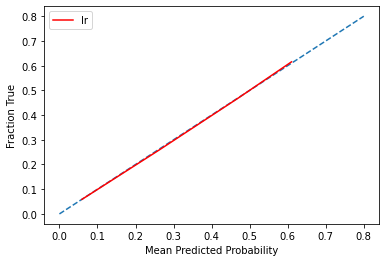

In [91]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = lr_calib.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [70]:
%%time
rfc_calib = CalibratedClassifierCV(base_estimator=rfc, method='isotonic', cv='prefit')
_ = rfc_calib.fit(X_valid_xfm, y_valid)

CPU times: user 19.7 s, sys: 345 ms, total: 20 s
Wall time: 20.2 s


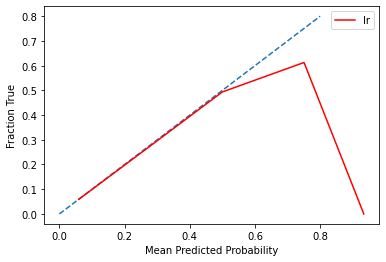

In [92]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = rfc_calib.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [71]:
%%time
ada_calib = CalibratedClassifierCV(base_estimator=ada, method='isotonic', cv='prefit')
_ = ada_calib.fit(X_valid_xfm, y_valid)

CPU times: user 6.47 s, sys: 2.46 s, total: 8.92 s
Wall time: 8.98 s


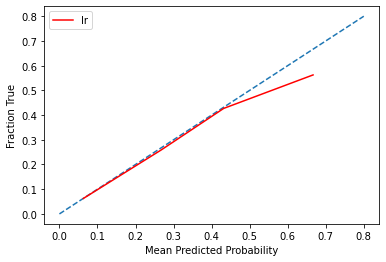

In [93]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = ada_calib.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [72]:
%%time
gb_calib = CalibratedClassifierCV(base_estimator=gb, method='isotonic', cv='prefit')
_ = gb_calib.fit(X_valid_xfm, y_valid)

CPU times: user 1.24 s, sys: 12.9 ms, total: 1.25 s
Wall time: 1.25 s


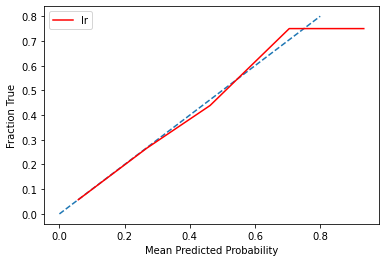

In [94]:
n_bins=5
plt.plot(np.arange(0,1,1/n_bins), np.arange(0,1,1/n_bins), '--')
y_test_pred_proba = gb_calib.predict_proba(X_test_xfm)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=n_bins)
plt.plot(prob_pred, prob_true, 'r', label='lr' )
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction True')
plt.legend() 

In [ ]:
knn_calib = CalibratedClassifierCV(base_estimator=knn, method='isotonic', cv='prefit')
knn_calib.fit(X_valid_xfm, y_valid)

In [111]:
version='2021-11-29'
dump(lr_calib, f'lr_calib_{version}.joblib')
dump(rfc_calib, f'rfc_calib_{version}.joblib')
dump(ada_calib, f'ada_calib_{version}.joblib')
dump(gb_calib, f'gb_calib_{version}.joblib')

['gb_calib2021-11-29.joblib']

In [95]:
from sklearn.model_selection import PredefinedSplit

X_stack = np.vstack((X_train_xfm, X_valid_xfm))
y_stack = np.hstack((y_train, y_valid))

test_fold = np.hstack((-1*np.ones_like(y_train), np.zeros_like(y_valid)))
ps = PredefinedSplit(test_fold)

In [ ]:
%%time
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(
    estimators=[('lr', lr), 
                # ('knn', knn_calib), 
                ('rfc', rfc),
                ('ada', ada),
                ('gb', gb)],
    cv=ps, 
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=4,
    verbose=3
)
stack.fit(X_stack, y_stack)

In [ ]:
y_train_pred_proba = stack.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = stack.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = stack.predict_proba(X_test_xfm)[:, 1]
tuned_results['stack'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(baseline_results['stack'], 'stacking')

In [ ]:
expLog

In [102]:
%%time
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[lr, rfc, ada, gb], 
                          meta_classifier=LogisticRegression(), 
                          use_probas=True,
                          fit_base_estimators=False, use_clones=False)
_ = sclf.fit(X_valid_xfm, y_valid)

/Users/deepakduggirala/miniforge3/lib/python3.9/site-packages/mlxtend/classifier/stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


CPU times: user 27.9 s, sys: 3.39 s, total: 31.3 s
Wall time: 30.2 s


In [107]:
%%time
y_train_pred_proba = sclf.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = sclf.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = sclf.predict_proba(X_test_xfm)[:, 1]
tuned_results['stack'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['stack'], 'stacking')

CPU times: user 2min 18s, sys: 15.8 s, total: 2min 34s
Wall time: 2min 31s


In [108]:
%%time
sclf_calib = StackingClassifier(classifiers=[lr_calib, rfc_calib, ada_calib, gb_calib], 
                          meta_classifier=LogisticRegression(), 
                          use_probas=True,
                          fit_base_estimators=False, use_clones=False)
_ = sclf_calib.fit(X_valid_xfm, y_valid)

/Users/deepakduggirala/miniforge3/lib/python3.9/site-packages/mlxtend/classifier/stacking_classification.py:160: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


CPU times: user 28.3 s, sys: 3.42 s, total: 31.8 s
Wall time: 30.7 s


In [109]:
%%time
y_train_pred_proba = sclf_calib.predict_proba(X_train_xfm)[:, 1]
y_valid_pred_proba = sclf_calib.predict_proba(X_valid_xfm)[:, 1]
y_test_pred_proba = sclf_calib.predict_proba(X_test_xfm)[:, 1]
tuned_results['stack_calib'] = (y_train_pred_proba, y_valid_pred_proba, y_test_pred_proba)

log_exp(tuned_results['stack_calib'], 'stacking_with_calibrated_base_ests')

CPU times: user 2min 18s, sys: 15.5 s, total: 2min 33s
Wall time: 2min 30s


In [112]:
dump(sclf, f'sclf_{version}.joblib')
dump(sclf_calib, f'sclf_calib_{version}.joblib')

['sclf_calib_2021-11-29.joblib']

In [110]:
expLoglr_calib

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC
0,logistic_reg_173_features,0.7075,0.7057,0.7062,0.7730,0.7717,0.7704
1,rfc_173_features,0.9722,0.8855,0.8855,0.9998,0.7722,0.7701
2,AdaBoost_173_features,0.9191,0.9194,0.9200,0.7657,0.7647,0.7617
3,gradient_boosting_173_features,0.9219,0.9199,0.9203,0.8090,0.7805,0.7791
4,stacking_173_features,0.9289,0.9197,0.9205,0.9479,0.7794,0.7776
5,stacking_with_calibrated_base_ests_173_features,0.9478,0.9196,0.9194,0.9755,0.7841,0.7806


## Kaggle Submission

In [62]:
X_kaggle_test = pipeline_with_selector.transform(processed_test_data)

def kaggle_submission_file(model, name):
    print(name)
    test_class_scores = model.predict_proba(X_kaggle_test)[:, 1]
    submit_df = processed_test_data[['SK_ID_CURR']].copy()
    submit_df['TARGET'] = test_class_scores
    submit_df.to_csv(f'{name}.csv', index=False)
    
models = {
    'lr': lr,
    # 'knn': knn,
    'rfc': rfc,
    'ada': ada,
    'gb': gb,
    # 'stack': stack
}

for name, model in models.items():
    kaggle_submission_file(model, name)

lr
rfc
ada
gb


In [63]:
!kaggle competitions submit -c home-credit-default-risk -f lr.csv -m "lr-0.7717"

100%|███████████████████████████████████████| 1.22M/1.22M [00:02<00:00, 601kB/s]
Successfully submitted to Home Credit Default Risk

In [64]:
!kaggle competitions submit -c home-credit-default-risk -f rfc.csv -m "rfc-0.7722"

100%|███████████████████████████████████████| 1.24M/1.24M [00:02<00:00, 522kB/s]
Successfully submitted to Home Credit Default Risk

In [65]:
!kaggle competitions submit -c home-credit-default-risk -f ada.csv -m "ada-0.7647"

100%|███████████████████████████████████████| 1.23M/1.23M [00:01<00:00, 695kB/s]
Successfully submitted to Home Credit Default Risk

In [66]:
!kaggle competitions submit -c home-credit-default-risk -f gb.csv -m "gb-0.7805"

100%|███████████████████████████████████████| 1.26M/1.26M [00:01<00:00, 840kB/s]
Successfully submitted to Home Credit Default Risk

![kaggle-submissions](images/kaggle-submissions.png)

In [114]:
models = {
    'sclf': sclf,
    'sclf_calib': sclf_calib
}

for name, model in models.items():
    kaggle_submission_file(model, name)

sclf
sclf_calib


In [115]:
!kaggle competitions submit -c home-credit-default-risk -f sclf.csv -m "sclf-0.7794"

100%|███████████████████████████████████████| 1.26M/1.26M [00:01<00:00, 914kB/s]
Successfully submitted to Home Credit Default Risk

In [116]:
!kaggle competitions submit -c home-credit-default-risk -f sclf_calib.csv -m "sclf_calib-0.7841"

100%|███████████████████████████████████████| 1.26M/1.26M [00:01<00:00, 819kB/s]
Successfully submitted to Home Credit Default Risk

![stacking-kaggle-scores](images/stacking-kaggle-scores.png)